# GEOG 313 Final




Function 1: Read in Sentinel-1 SAR 

	- Inputs: AOI, date range 
	- Outputs: Median quarterly composites (mosaiced) of VH and VV bands 

Function 2: Create index time series 

	- Inputs: median quarterly composites, name of index (RVI, mRFDI) 
	- Outputs: time series of index value 

Function 3: Create Visualizations within subzones 

	- Inputs: time series, subzones 
	- outputs: graph of index value vs time for each subzone. 

Function 4: Visualize trends 

	- Inputs: time series, name of trend (linear, monotonic, etc) 
	- outputs: raster image of correlation coefficient or other values (depending on what trend is used- ex. for linear trend it would output two images, r value and correlation coefficient) 

Function 5: detect deforestation 

	- Inputs: time series, index threshold value 
	- outputs: image of what year deforestation occurred (when value decreased below the user-defined threshold. If the value decreased then increased the result will be inconclusive and marked with an appropriate value) 



In [1]:
import dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
print(client.dashboard_link)

http://127.0.0.1:8787/status


2024-12-04 18:26:12,879 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:35187 (pid=1095) exceeded 95% memory budget. Restarting...
2024-12-04 18:26:13,071 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:35187' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('getitem-cafc390b4035bc237580505ff66db5d7', 3, 1, 2), ('rechunk-split-4dbc5cb5b08d78041e00eb494914344a', 37), ('rechunk-split-4dbc5cb5b08d78041e00eb494914344a', 156), ('getitem-d9061b6268555796930e26280c81ec91', 1, 0, 0, 1), ('getitem-d9061b6268555796930e26280c81ec91', 6, 1, 0, 1), ('rechunk-split-4dbc5cb5b08d78041e00eb494914344a', 229), ('rechunk-split-6c192076d667d5d0464f09dfc96c8cf4', 38), ('rechunk-split-6c192076d667d5d0464f09dfc96c8cf4', 56), ('rechunk-split-6c192076d667d5d0464f09dfc96c8cf4', 1), ('rechunk-split-6c192076d667d5d0464f09dfc96c8cf4', 10), ('getitem-8878d17dc2a11c0b034b1ba05c2d7c68', 15, 1, 1, 1), ('rechunk-split-4dbc5cb5b08d78041e00eb4949

In [3]:
aoi = [38.5, -5.25, 38.75,-4.75]

start = "2020-01-01"
end = "2020-12-31"

bands = ["VV", "VH"]

In [4]:
search = get_sar_pc(aoi, start, end)
search

subset = search[0]
subset

<Item id=S1B_IW_GRDH_1SDV_20201227T030420_20201227T030445_024882_02F5EA_rtc>

In [5]:

stack = stackstac.stack(
    search,
    epsg=32737,
    resolution=20,
    bounds_latlon=aoi,
    )
stack

<xarray.DataArray 'stackstac-703d48e8f891d5c6ef662895f10ae78d' (time: 76,
                                                                band: 2,
                                                                y: 2766, x: 1388)> Size: 5GB
dask.array<fetch_raster_window, shape=(76, 2, 2766, 1388), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * time                                   (time) datetime64[ns] 608B 2020-01...
    id                                     (time) <U66 20kB 'S1A_IW_GRDH_1SDV...
  * band                                   (band) <U2 16B 'vh' 'vv'
  * x                                      (x) float64 11kB 4.445e+05 ... 4.7...
  * y                                      (y) float64 22kB 9.475e+06 ... 9.4...
    sat:absolute_orbit                     (time) int64 608B 30754 ... 24882
    ...                                     ...
    sar:frequency_band                     <U1 4B 'C'
    s1:instrument_configuration_ID         (time) <U1 304B '6' '6' ... '6' '1'
    title                                  (band) <U41 328B 'VH: vertical tra...
    description                            (band) <U173 1kB 'Terrain-correcte...
    raster:bands                           object 8B {'nodata': -32768, 'data...
    epsg                                   int64 8B 32737
Attributes:
    spec:        RasterSpec(epsg=32737, bounds=(444540, 9419660, 472300, 9474...
    crs:         epsg:32737
    transform:   | 20.00, 0.00, 444540.00|\n| 0.00,-20.00, 9474980.00|\n| 0.0...
    resolution:  20

2024-12-04 18:24:18,156 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 0.98 GiB -- Worker memory limit: 1.48 GiB
2024-12-04 18:24:51,977 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 1.19 GiB -- Worker memory limit: 1.48 GiB
2024-12-04 18:24:51,997 - distributed.worker.memory - WARNING - Worker is at 63% memory usage. Resuming worker. Process memory: 0.94 GiB -- Worker memory limit: 1.48 GiB
2024-12-04 18:25:28,198 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memo

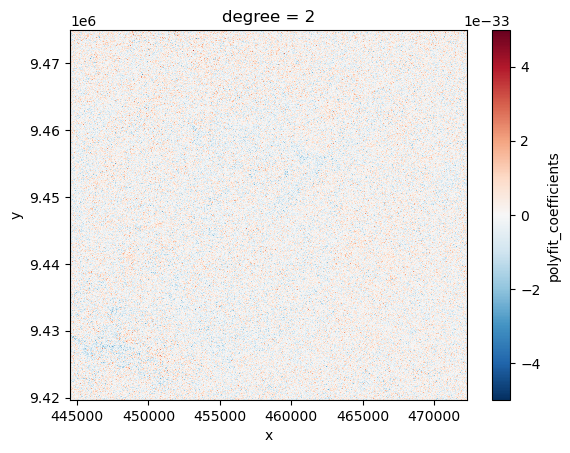

In [20]:
q_composite = quartely_composite(stack)
q_composite

index = calculate_index(q_composite)

# TO do- values within subzones


In [ ]:
trends = linear_trend(index)
linecoeff = trends.sel(degree = 2)

linecoeff.polyfit_coefficients.plot()

In [19]:
import xarray as xr
import rioxarray as rxr
import numpy as np
import stackstac
import os
import leafmap
import requests
from tqdm import tqdm
import pystac_client
import planetary_computer
from matplotlib import pyplot as plt

# write function to get bbox for polygons


def get_sar_pc(bbox, start, end):

    catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",  # connect to Planetary Computer API
    modifier=planetary_computer.sign_inplace,               
    )

    search = catalog.search(
        collections=["sentinel-1-rtc"],       # get sentienel 2 l2a
        bbox=bbox,                             # within bbox
        datetime = f"{start}/{end}",          # within specified dates
       #query = ["sar:polarizations[0]"],
    )

    items = search.get_all_items()  # get items into new variable
    return items


def items_to_xarray(items, bands):
    stack = stackstac.stack(
        items,                 # output of item collection search
   #     bounds_latlon=bbox,       # clip to bbox
        assets=bands           # get only green and nir bands
    )
    
    return stack

def quartely_composite(stack):
    composite = stack.resample(time="1Q").median("time")

    return composite

def calculate_index(stack):
    vh, vv = stack.sel(band = "vh"), stack.sel(band = "vv")

    mRFDI = (vv-vh)/(vv+vh)
    
    return mRFDI

def linear_trend(stack):
    trend = stack.polyfit(dim = "time", deg = 2)
    return trend